## Final Project Submission

Please fill out:
* Student name: Karen Amanya
* Student pace:Part Time 
* Scheduled project review date/time: 9th November 2022
* Instructor name: 
* Blog post URL:


### Business Problem

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.


In [136]:
Image(url="Images/joker.jpeg", width=800, height=300)

### Data Understanding and Preparation

In [125]:
from IPython.display import Image
import pandas as pd
import json 
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import datetime
%matplotlib inline

In [ ]:
#contains info about movie 
#Looking into movie genres - required columns are genre , rating and the movie id for identification
movieGenres = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movieGenres.info()
movieGenres.head()

In [62]:
#Find duplicated rows
movieGenres[movieGenres.duplicated(subset = ['id','original_title'])]

#Drop duplicate rows
movieGenres.drop_duplicates(subset = ['id','original_title'], inplace =True)

#Drop unneeded columns 
movieGenres = movieGenres.drop(columns = ['Unnamed: 0','original_language','title'])

#Convert columns to correct datatypes
movieGenres['release_date'] = pd.to_datetime(movieGenres['release_date'])
movieGenres['genre_ids'] = movieGenres['genre_ids'].map(lambda x:json.loads(x))

# New dataframe with only rows with a genre id
movieGenres2 = movieGenres[movieGenres['genre_ids'].str.len() != 0]

#An API for movie info
key = '285b515026fc64dcb3ed554f31f600d5'
response1 = requests.get(f'https://api.themoviedb.org/3/genre/movie/list?api_key=285b515026fc64dcb3ed554f31f600d5&language=en-US').json()
genre_Key = response1['genres']

#a function that returns the genre name given an id
def mapGenre(Id):
    global genre_Key
    for item in genre_Key:
        if item['id'] == Id:
            genre = item['name']
    return genre

#to create a new column with movie genre name
genres = list(movieGenres2['genre_ids'].map(lambda x : mapGenre(x[0])))
movieGenres2.insert(3,'movie_genre',genres)

#drop genre ids column as it is no longer needed 
movieGenres2 = movieGenres2.drop('genre_ids', axis = 1)
movieGenres2.head()

,id,original_title,movie_genre,popularity,release_date,vote_average,vote_count
0,12444,Harry Potter and the Deathly Hallows: Part 1,Adventure,33.533,2010-11-19,7.7,10788
1,10191,How to Train Your Dragon,Fantasy,28.734,2010-03-26,7.7,7610
2,10138,Iron Man 2,Adventure,28.515,2010-05-07,6.8,12368
3,862,Toy Story,Animation,28.005,1995-11-22,7.9,10174
4,27205,Inception,Action,27.920,2010-07-16,8.3,22186


In [63]:
#merge all datasets containing revenues of movies
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz',usecols=['movie','worldwide_gross'])
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].replace(",", "",regex=True).replace({r'\$':""},regex=True).astype(float)

movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz',usecols = ['title','studio','domestic_gross','foreign_gross'])
movie_gross['domestic_gross'] = movie_gross['domestic_gross'].astype(float)
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].replace(",", "",regex=True).astype(float)
movie_gross['worldwide_gross'] = movie_gross['domestic_gross'] + movie_gross['foreign_gross']
movie_gross.rename(columns = {'title':'movie'},inplace = True)
movie_gross = movie_gross[['movie','worldwide_gross','studio']]

#Filter out movies with a gross of 0
movie_budgets = movie_budgets.loc[movie_budgets['worldwide_gross'] != 0]
movie_gross = movie_gross.loc[movie_gross['worldwide_gross'] != 0]

#merge the datasets
revenues_1 = pd.concat([movie_budgets,movie_gross], axis = 0)
revenues_1.drop_duplicates(subset =[ 'movie'], inplace = True)
revenues_1.head()

,movie,worldwide_gross,studio
0,Avatar,2.776345e+09,NaN
1,Pirates of the Caribbean: On Stranger Tides,1.045664e+09,NaN
2,Dark Phoenix,1.497624e+08,NaN
3,Avengers: Age of Ultron,1.403014e+09,NaN
4,Star Wars Ep. VIII: The Last Jedi,1.316722e+09,NaN


#### Use IMDB api to get revenues of movies not avaliable in the datasets

In [ ]:
List = list(movieGenres['id'])
Dict = dict.fromkeys(List[0:len(List)])
key = '285b515026fc64dcb3ed554f31f600d5'
for Id in Dict:
    try:
        response = requests.get(f'https://api.themoviedb.org/3/movie/{Id}?api_key={key}&language=en-US').content
        rev = json.loads(response)['revenue']
    except KeyError:
        rev = 0
    except JSONDecodeError:
        rev = 0
    Dict[Id] = rev
    
# Add response to dictionary
for i in Dict:
    main_Dict[i] = Dict[i]

#Create json file and dump response
with open("Revenues.json", "w") as outfile:
    json.dump(main_Dict, outfile)

In [64]:
#Fetch movie movie revenue data from IMDB API using the movie id
revenueJson = pd.read_json('Revenues.json', typ = 'series')
ids = list(revenueJson.index)
values = list(revenueJson.values)
revenues_2 = pd.DataFrame({'id':ids,'worldwide_gross':values}, columns = ['id','worldwide_gross'])
idKey = dict(zip(list(movieGenres2['id']),list(movieGenres2['original_title'])))
revenues_2['movie'] = revenues_2['id'].map(lambda x: idKey[x])

#Merge the two dataframes with revenue data
movieRevenues = pd.concat([revenues_1, revenues_2], axis = 0)
movieRevenues.drop_duplicates(subset = ['movie'], inplace = True)
movieRevenues.head()

#Merge with the original dataframe
movieGenres2.rename(columns = {'original_title':'movie'},inplace = True)
movieData = pd.merge(movieGenres2,movieRevenues[['movie','worldwide_gross','studio']], on = 'movie')
movieData.drop_duplicates(subset = ['movie'], inplace = True)
movieData.head()

,id,movie,movie_genre,popularity,release_date,vote_average,vote_count,worldwide_gross,studio
0,12444,Harry Potter and the Deathly Hallows: Part 1,Adventure,33.533,2010-11-19,7.7,10788,954305868.0,NaN
1,10191,How to Train Your Dragon,Fantasy,28.734,2010-03-26,7.7,7610,494870992.0,NaN
2,10138,Iron Man 2,Adventure,28.515,2010-05-07,6.8,12368,621156389.0,NaN
3,862,Toy Story,Animation,28.005,1995-11-22,7.9,10174,364545516.0,NaN
4,27205,Inception,Action,27.920,2010-07-16,8.3,22186,835524642.0,NaN


In [65]:
movieData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15406 entries, 0 to 15921
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               15406 non-null  int64         
 1   movie            15406 non-null  object        
 2   movie_genre      15406 non-null  object        
 3   popularity       15406 non-null  float64       
 4   release_date     15406 non-null  datetime64[ns]
 5   vote_average     15406 non-null  float64       
 6   vote_count       15406 non-null  int64         
 7   worldwide_gross  14942 non-null  float64       
 8   studio           779 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.2+ MB


### Data Analysis

####  1. Movie Genres

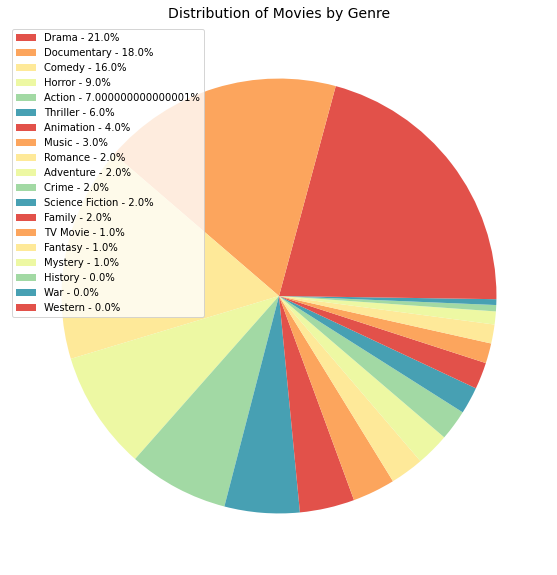

In [66]:
# Movie genres
genres = pd.DataFrame(movieData['movie_genre'].value_counts())

#Plot the different genres
plt.figure(figsize =(12,10))
plt.title('Distribution of Movies by Genre', fontsize=14)
genre_labels = list(genres.index)
genre_values = list(genres['movie_genre'])
Sum = sum(list(genres['movie_genre']))
d = dict(zip(genre_labels,genre_values))
legend_values = []
for i in d:
    legend_values.append(f'{i} - {round(d[i] /Sum,2)*100}%')

colours = sns.color_palette("Spectral")[0:len(genre_labels)]
plt.pie(genres['movie_genre'],colors = colours)
plt.legend(legend_values, loc = 'best')
plt.show()

Observations:
1. The most produced movies genres are Drama ,Comedy,Documentary.
2. Western , War and Hitory are the genres with the least movies.

#### 2. Movie Revenues according to Genre

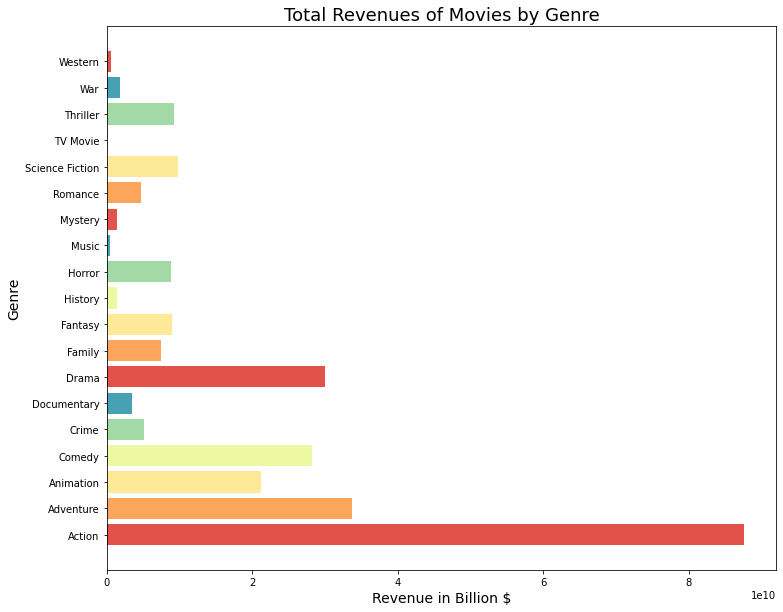

In [67]:
#Genres vs Revenues
genres_vs_revenues = movieData[movieData['worldwide_gross'].notnull()]
genres_vs_revenues = genres_vs_revenues.sort_values('worldwide_gross').groupby(
                                                                      'movie_genre', 
                                                                       as_index=False).agg({'worldwide_gross':pd.Series.sum},inplace = True
                                                                              )
#Plot the different genres
plt.figure(figsize = (12,10))
plt.title('Total Revenues of Movies by Genre', fontsize=18)
plt.xlabel('Revenue in Billion $',fontsize=14)
plt.ylabel('Genre',fontsize=14)
colours = sns.color_palette("Spectral")[0:len(list(genres_vs_revenues['movie_genre']))]
plt.barh(genres_vs_revenues['movie_genre'], genres_vs_revenues['worldwide_gross'], color = colours)
plt.show();

Observations :
1. Action movies have the highest grossing revenues worldwide.
2. Drama which has the most movies produced also has high revenues.
3. Movies categorized under Western , TV movie and Music generate the least revenue worldwide.

Action , Adventure and Drama have the highest gross revenues while TV movie, Western and Music have the lowest gross revenues

#### 3. Top 1000 Movies with the Highest Revenues

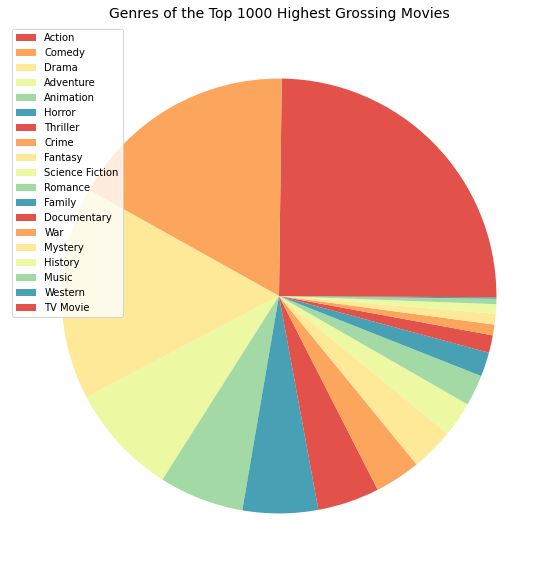

In [68]:
# top 1000 grossing movies and their genres
movieData2 = movieData[movieData['worldwide_gross'].notnull()]
top1000_grossing_movies = movieData2.sort_values('worldwide_gross', ascending = False).head(1000)
top1000_grossing_movies_genres = pd.DataFrame(top1000_grossing_movies['movie_genre'].value_counts())

colours = sns.color_palette("Spectral")[0:len(list(top1000_grossing_movies_genres.index))]
#Plot the different genres
plt.figure(figsize =(12,10))
plt.title('Genres of the Top 1000 Highest Grossing Movies', fontsize=14)
labels = list(top1000_grossing_movies_genres.index)

colours = sns.color_palette("Spectral")[0:len(labels)]
plt.pie(top1000_grossing_movies_genres['movie_genre'], colors = colours)
plt.legend(labels, loc = 'best')
plt.show()

Observations:
1. Action movies dominate the top 1000 movies with the highest gross revenues.
2. A few movies in the western and TV movie genres also appear in the top 1000 list.

#### 4. Movie Ratings and Votes

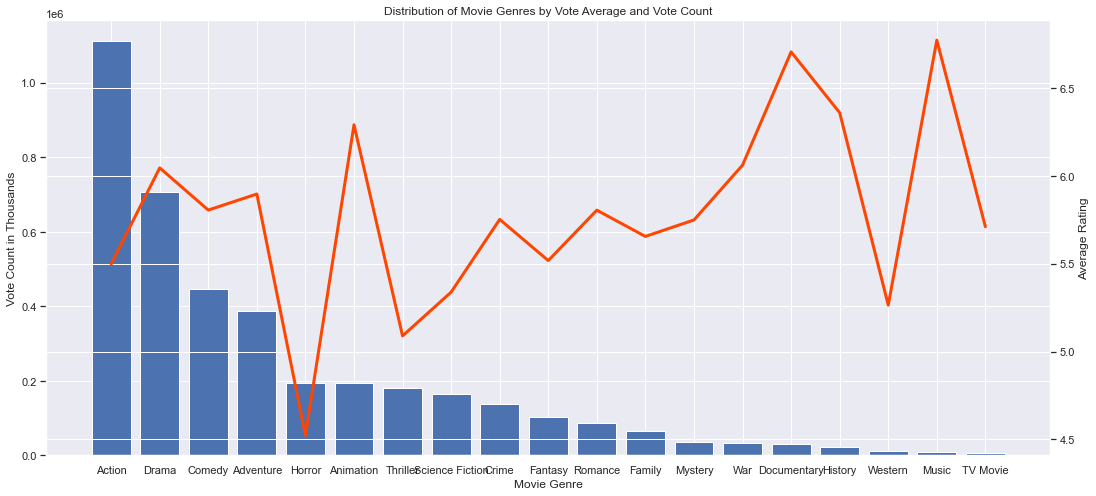

In [144]:
#Ratings and Vote counts accounding to genre 
genre_ratings = movieData2.groupby(['movie_genre'], as_index =  False).agg({'vote_count':sum,'vote_average':np.mean}).sort_values('vote_count',ascending = False)

fig, ax1 = plt.subplots(figsize=(18,8))
colours = sns.color_palette("Spectral")[0:len(list(genre_ratings['movie_genre']))]
ax1.bar(genre_ratings['movie_genre'],genre_ratings['vote_count'])
ax1.set_xlabel('Movie Genre')
ax1.set_ylabel('Vote Count in Thousands')
ax2 = ax1.twinx()
ax2.plot(genre_ratings['movie_genre'],genre_ratings['vote_average'], linewidth = 3, color = 'orangered')
ax2.set_ylabel('Average Rating')
plt.title('Distribution of Movie Genres by Vote Average and Vote Count')
plt.show()

Observations:
1. Action movies have the highest number of votes  but also had low average ratings.
2. Horror movies have the lowest average ratings.
3. Musical movies have the highest average ratings but also a very low vote count.

#### 5. Movie Genres by Vote Average and Gross Revenues

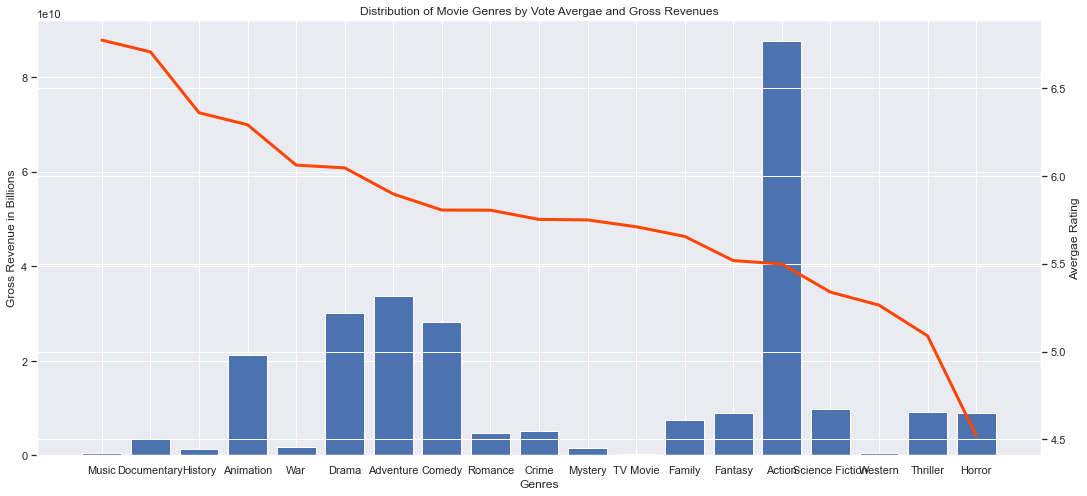

In [145]:
#Movie Reveneus vs Ratings
rev_vs_ratings = movieData2.groupby(['movie_genre'], as_index =  False).agg({'worldwide_gross':sum,'vote_average':np.mean}).sort_values('vote_average',ascending = False)

fig, ax1 = plt.subplots(figsize=(18,8))
ax1.bar(rev_vs_ratings['movie_genre'],rev_vs_ratings['worldwide_gross'])
ax1.set_xlabel('Genres')
ax1.set_ylabel('Gross Revenue in Billions')
ax2 = ax1.twinx()
ax2.set_ylabel('Avergae Rating')
ax2.plot(rev_vs_ratings['movie_genre'],rev_vs_ratings['vote_average'], linewidth = 3, color = 'orangered')
plt.title('Distribution of Movie Genres by Vote Avergae and Gross Revenues')
plt.show()

Observations:
1. Movies with very high revenues did not have high ratings.
2. Movies with high ratings also did not have high revenues.

#### 8. Release Dates of the Top 1000 Movies 


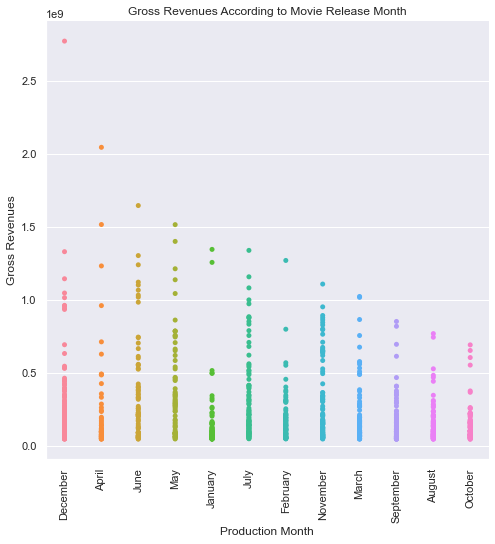

In [142]:
def Month(month_no):
    month_name = datetime.date(1900, month_no, 1).strftime('%B')
    return month_name
# Create column with only the month that the movie was released   
top1000_grossing_movies['month'] = top1000_grossing_movies['release_date'].map(lambda x: Month(x.month))
release_dates = top1000_grossing_movies.groupby('month', as_index= False).agg({'worldwide_gross':sum}).sort_values('worldwide_gross',ascending = False)

#Plot
ax = sns.catplot( data=top1000_grossing_movies, x="month", y="worldwide_gross", jitter=False, height = 7)
ax.set(title = 'Gross Revenues According to Movie Release Month',
       xlabel = 'Production Month',
       ylabel = 'Gross Revenues')
plt.xticks(rotation=90);

Observations:
1. Movies released in December , April , June and May had the highest revenues.
2. Movies released in October, August and September had lower revenues.


### Conclusion

Findings the analysis done on the movie data:
1. The data shows that movie genres are very significant to a movie's performance at the box office. Some genres such as action and adventure are more popular than others and this is evidenced by the count of movies produced - where Drama, Documentary , Comedy , Adventure and Action had the highest number of production.

2. Vote count is more significant than the rating average - the more reviews and votes a movie receives in the various movie sites such as rottentomatoes, IMDB and others builds the popularity of a movie which encourages viewership.

3. The rating of a movie does not have a direct effect on the revenue it generates at the box office. Some movies with relatively high ratings also generated relatively low revenues and vise versa.

### Recommendations

 From the findings of my analysis , I would recommmend to Microsoft the below actions:
 
 1. Focus movie production to particular genres such as drama , comedy and action as they already have a huge viewership and audience and to avoid producing movies in the war, music and tv movie categories as they have very few leadership and this would results in low popularity and hence low revenues.

 2. Direct resources to marketing especially on the popular review sites - where alot of people review / vote for a movie on such websites it results in popularity among audiences which will promote viewership at cinemas and generate high revenues.
 
 3. To set movie release dates during specific months that have a high score of movie revenue generation such as December, June and April.